In [ ]:
! pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, b

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from itertools import count
from typing import Union, Tuple, Callable

## Task 1: Replay Buffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, size: int = 10000):
        """
        Constructor

        Parameters
        ----------
        size
            Maximum number of transitions store in the buffer.
            If the buffer overflows, older states are dropped.
        """
        self.size    = size
        self.length  = 0
        self.idx     = -1

        # define buffers
        self.states        = None
        self.states_next   = None
        self.actions       = None
        self.rewards       = None
        self.done          = None

    def store(self,
              s: Union[torch.Tensor, np.ndarray],
              a: int,
              r: float,
              s_next: Union[torch.Tensor, np.ndarray],
              done: bool):

        """
        Stores one sample of experience

        Parameters
        ----------
        s
            Tensor encoding the current state.
        a
            Current action.
        r
            Current reward.
        s_next
            Tensor encoding the next state.
        done
            Done signal.
        """

        # initialize buffers
        if self.states is None:
            self.states      = torch.zeros([self.size] + list(s.shape))   # shape is (self.size, 4)
            self.states_next = torch.zeros_like(self.states)              # shape is (self.size, 4)
            self.actions     = torch.zeros((self.size, ))                 # shape is (self.size, )
            self.rewards     = torch.zeros((self.size, ))                 # shape is (self.size, )
            self.done        = torch.zeros((self.size, ))                 # shape is (self.size, )

        # TODO: store current (s, a, r, s_next, done) behavior sample in the corresponding tensor buffers
        # Note 1: older instances are overwritten if the buffer overflows.
        # Note 2: increment buffer length after each update, until it reaches the maximum allowed value: self.size

        # Circular index update
        self.idx = (self.idx + 1) % self.size

        # Store transition (s, a, r, s_next, done)
        self.states[self.idx] = torch.as_tensor(s, dtype=torch.float32)
        self.states_next[self.idx] = torch.as_tensor(s_next, dtype=torch.float32)
        self.actions[self.idx] = a
        self.rewards[self.idx] = r
        self.done[self.idx] = done

        # Update buffer length
        if self.length < self.size:
            self.length += 1

    def sample(self, batch_size: int = 128) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
        """
        Sample a batch of experience

        Parameters
        ----------
        batch_size
            Number of experience to sample

        Returns
        -------
        Tuple of tensor consisting of a batch of states, actions, rewards, next states, done
        """

        assert self.length >= batch_size, "Can not sample from the buffer yet"
        indices = np.random.choice(a=np.arange(self.length), size=batch_size, replace=False)

        # Sample (s, a, r, s_next, done) behavior samples
        # s      = ...         (batch_size, 4)
        # s_next = ...    (batch_size, 4)
        # a = ...              (batch_size, )
        # r = ...               (batch_size, )
        # done = ...    (batch_size, )

        s      = self.states[indices]
        a      = self.actions[indices].long()
        r      = self.rewards[indices]
        s_next = self.states_next[indices]
        done   = self.done[indices]

        return s, a, r, s_next, done

## Network achitecture

In [ ]:
class DQN_RAM(nn.Module):
    def __init__(self, in_features: int, num_actions: int):
        """
        Initialize a deep Q-learning network for testing algorithm

        Parameters
        ----------
        in_features
            number of features of input.
        num_actions
            number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN_RAM, self).__init__()
        self.in_features = in_features
        self.num_actions = num_actions

        # define architecture
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Epsilon scheduler

In [ ]:
def eps_generator(max_eps: float=1.0, min_eps: float=0.1, max_iter: int = 10000):
    crt_iter = -1

    while True:
        crt_iter += 1
        frac = min(crt_iter/max_iter, 1)
        eps = (1 - frac) * max_eps + frac * min_eps
        yield eps

## Epsilon greedy policy

In [ ]:
def select_epilson_greedy_action(Q: nn.Module, s: Tensor, eps: float):
    rand = np.random.rand()

    # with prob eps select a random action
    if rand < eps:
        return np.random.choice(np.arange(Q.num_actions))

    # select best action
    with torch.no_grad():
        output = Q(s).argmax(dim=1).item()

    return output

## Task 2: DQN target

In [ ]:
@torch.no_grad()
def dqn_target(
    Q: nn.Module,
    target_Q: nn.Module,
    r_batch: Tensor,
    s_next_batch: Tensor,
    done_batch: Tensor,
    gamma: float) -> Tensor:
    """
    Computes DQN target

    Parameters:
    -----------
    Q
        Behavior Q network.
    target_Q
        Target Q network.
    r_batch
        Batch of rewards.
    s_next_bacth
        Batch of next states.
    done_batch
        Batch of done flag (1 means the episoded finished).
    gamma
        Discount factor.

    Returns
    -------
    Batch of DQN targets
    """
    # compute next Q value based on which action gives max Q values
    # Note:  decorator torch.no_grad() ensures that gradients computed based on next Q are not propagated to the target_Q network
    # Note: take note of the done_batch values - if behavior sample i in the batch has a done flag (done_batch[i] = 1), then the next_Q_values[i]
    #             will only consider the reward[i] (because there is no next_state)

    # next_Q_values = ....

    # Compute max Q value over all actions using the target network
    next_Q_values = target_Q(s_next_batch).max(dim=1).values

    # Zero out next Q values for terminal states
    next_Q_values = (1 - done_batch) * next_Q_values

    # Return TD target: r + γ * max_a Q_target(s', a)
    return r_batch + gamma * next_Q_values

## Task 3: DDQN target

$target_t = R_{t+1} + \gamma Q_{target}(S_{t+1}, \underset{a}{\operatorname{argmax}} Q(S_{t+1}, a; \theta_{t}); \theta_t^{-})$

In [ ]:
@torch.no_grad()
def ddqn_target(
    Q: nn.Module,
    target_Q: nn.Module,
    r_batch: Tensor,
    s_next_batch: Tensor,
    done_batch: Tensor,
    gamma: float) -> Tensor:
    """
    Computes DQN target

    Parameters:
    -----------
    Q
        Behavior Q network.
    target_Q
        Target Q network.
    r_batch
        Batch of rewards.
    s_next_bacth
        Batch of next states.
    done_batch
        Batcho of done flag (1 means the episoded finished).
    gamma
        Discount factor.

    Returns
    -------
    Batch of DQN targets
    """
    # cmpute next Q value based on which action gives max Q values
    #  next_Q_values = ...

    # Select best actions in next states using the online network
    best_actions = Q(s_next_batch).argmax(dim=1)  # shape: (batch_size,)

    # Evaluate those actions using the target network
    target_q_values = target_Q(s_next_batch).gather(1, best_actions.unsqueeze(1)).squeeze(1)

    # Zero next_Q_values if episode is done
    next_Q_values = (1 - done_batch) * target_q_values

    # Compute TD target
    return r_batch + gamma * next_Q_values

##  Learning Alogrithm

In [ ]:
def learning(
    env: gym.Env,
    target_function: Callable,
    batch_size: int = 128,
    gamma: float = 0.99,
    replay_buffer_size=10000,
    num_episodes: int = 100000,
    learning_starts: int = 1000,
    learning_freq: int = 4,
    target_update_freq: int = 100,
    log_every: int = 100):

    """
    DQN Learning

    Parameters
    ----------
    env
        gym environment to train on.
    target_function
        Function that computes the Q network target. For DQN - dqn_target, for DDQN - ddqn_target.
    batch_size:
        How many transitions to sample each time experience is replayed.
    gamma
        Discount Factor
    replay_buffer_size
        Replay buffer size.
    num_episodes
        number of episodes to run
    learning_starts: int
        After how many environment steps to start replaying experiences
    learning_freq: int
        How many steps of environment to take between every experience replay
    target_update_freq: int
        How many experience replay rounds (not steps!) to perform between
        each update to the target Q network
    log_every:
        Logging interval
    """
    # This means we are running on low-dimensional observations (e.g. RAM)
    input_arg = env.observation_space.shape[0]
    num_actions = env.action_space.n

    # define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize target q function and q function
    Q = DQN_RAM(input_arg, num_actions).to(device)
    target_Q = DQN_RAM(input_arg, num_actions).to(device)

    # Construct Q network optimizer function
    optimizer = optim.Adam(Q.parameters(), lr=1e-3)

    # define criterion
    criterion = nn.MSELoss()

    # Construct the replay buffer
    replay_buffer = ReplayBuffer()

    # define epsilon scheduler
    eps_scheduler = iter(eps_generator())

    # define statistics buffer, total number of steps and total number of updates performed
    all_episode_rewards = []
    total_steps = 0
    num_param_updates = 0

    for episode in range(1, num_episodes + 1):
        # reset environment
        s = env.reset()
        episode_reward = 0

        for _ in count():
            # increse total number of steps
            total_steps += 1

            # Choose random action if not yet start learning
            if total_steps > learning_starts:
                eps = next(eps_scheduler)
                s = torch.tensor(s).view(1, -1).float().to(device)
                a = select_epilson_greedy_action(Q, s, eps)
            else:
                a = np.random.choice(np.arange(num_actions))

            # advance one step
            s_next, r, done, _ = env.step(a)

            # update episode rewards
            episode_reward += r

            # store other info in replay memory
            replay_buffer.store(s, a, r, s_next, done)

            # Resets the environment when reaching an episode boundary.
            if done:
                break

            # update state
            s = s_next

            # perform experience replay and train the network.
            if (total_steps > learning_starts and total_steps % learning_freq == 0):
                for _ in range(learning_freq):
                    # sample experinence from the replay buffer
                    s_batch, a_batch, r_batch, s_next_batch, done_batch = replay_buffer.sample(batch_size)

                    # send everything to device
                    s_batch      = s_batch.float().to(device)
                    a_batch      = a_batch.long().to(device)
                    r_batch      = r_batch.float().to(device)
                    s_next_batch = s_next_batch.float().to(device)
                    done_batch   = done_batch.long().to(device)

                    # comput the q values according to the states and actions
                    Q_values = Q(s_batch).gather(1, a_batch.unsqueeze(1)).view(-1)

                    # Compute the target of the current Q values
                    target_Q_values = target_function(Q, target_Q, r_batch, s_next_batch, done_batch, gamma)

                    # compute loss
                    loss = criterion(target_Q_values, Q_values)

                    # Clear previous gradients before backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # increase number of updates
                    num_param_updates += 1

                    # Periodically update the target network by Q network to target Q network
                    if num_param_updates % target_update_freq == 0:
                        target_Q.load_state_dict(Q.state_dict())

        # append total reward culumated
        all_episode_rewards.append(episode_reward)

        # log average reward over the last 100 episodes
        if episode % log_every == 0 and total_steps > learning_starts:
            mean_episode_reward = np.mean(all_episode_rewards[-100:])
            print("Episode: %d, Mean reward: %.2f, Eps: %.2f" % (episode, mean_episode_reward, eps))


## DQN Learning

#### Task 4a: Modify learning procedure to implement original DQN (model and target networks are the same)
#### Task 4b: Modify learning procedure to implement target network DQN

**Note: Experiment with different values of:**
  - learning_freq
  - target_update_frequency
  - epsilon decay rate

In [ ]:
# initialize gym env
env = gym.make("CartPole-v1")

# DQN learning
learning(
    env=env,                          # gym environmnet
    target_function=dqn_target,      # dqn target construction
    batch_size=128,                   # q-network update batch size
    gamma=0.99,                       # discount factor
    replay_buffer_size=10000,         # size of the replay buffer
    num_episodes=1000,                # number of episodes to run
    learning_starts=1000,             # number of initial random actions (exploration)
    learning_freq=8,                  # frequency of the update
    target_update_freq=50,           # number of gradient steps after which the target network is updated
    log_every=100                     # logging interval. returns the mean reward per episode.
)

Episode: 100, Mean reward: 22.66, Eps: 0.77
Episode: 200, Mean reward: 132.46, Eps: 0.10
Episode: 300, Mean reward: 333.15, Eps: 0.10
Episode: 400, Mean reward: 403.87, Eps: 0.10
Episode: 500, Mean reward: 309.29, Eps: 0.10
Episode: 600, Mean reward: 277.61, Eps: 0.10
Episode: 700, Mean reward: 226.76, Eps: 0.10
Episode: 800, Mean reward: 239.63, Eps: 0.10
Episode: 900, Mean reward: 207.10, Eps: 0.10
Episode: 1000, Mean reward: 196.28, Eps: 0.10


In [ ]:
import matplotlib.pyplot as plt
import re

def plot_from_log_text(raw_text, label="DQN"):
    episodes = []
    rewards = []

    # Sparge textul în linii
    lines = raw_text.strip().split('\n')

    # Caută și extrage episodul + reward-ul din fiecare linie
    for line in lines:
        match = re.search(r"Episode:\s*(\d+), Mean reward:\s*([\d.]+)", line)
        if match:
            episodes.append(int(match.group(1)))
            rewards.append(float(match.group(2)))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, rewards, marker='o', label=label)
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward")
    plt.title("Learning Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
log_text = """
Episode: 100, Mean reward: 22.66, Eps: 0.77
Episode: 200, Mean reward: 132.46, Eps: 0.10
Episode: 300, Mean reward: 333.15, Eps: 0.10
Episode: 400, Mean reward: 403.87, Eps: 0.10
Episode: 500, Mean reward: 309.29, Eps: 0.10
Episode: 600, Mean reward: 277.61, Eps: 0.10
Episode: 700, Mean reward: 226.76, Eps: 0.10
Episode: 800, Mean reward: 239.63, Eps: 0.10
Episode: 900, Mean reward: 207.10, Eps: 0.10
Episode: 1000, Mean reward: 196.28, Eps: 0.10
"""

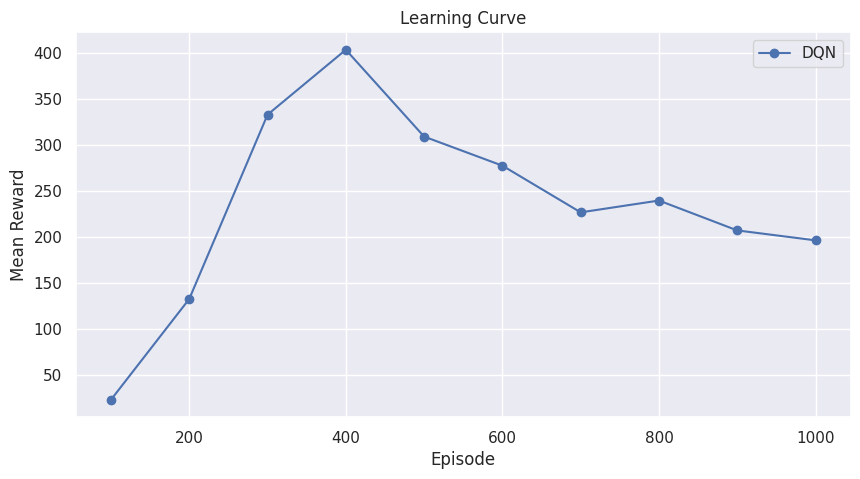

In [ ]:
plot_from_log_text(log_text, label="DQN")

## DDQN Learning
**Note: Experiment with different values of:**
  - learning_freq
  - target_update_frequency
  - epsilon decay rate

In [ ]:
# initialize gym env
env = gym.make("CartPole-v1", max_episode_steps=200)

# DQN learning
learning(
    env=env,                          # gym environmnet
    target_function=ddqn_target,     # dqn target construction
    batch_size=128,                   # q-network update batch size
    gamma=0.99,                       # discount factor
    replay_buffer_size=10000,         # size of the replay buffer
    num_episodes=1000,                # number of episodes to run
    learning_starts=1000,             # number of initial random actions  (exploration)
    learning_freq=4,                  # frequency of the update
    target_update_freq=50,           # number of gradient steps after which the target network is updated
    log_every=100                     # logging interval. returns the mean reward per episode.
)

Episode: 100, Mean reward: 22.16, Eps: 0.89
Episode: 200, Mean reward: 39.51, Eps: 0.54
Episode: 300, Mean reward: 91.00, Eps: 0.10
Episode: 400, Mean reward: 167.23, Eps: 0.10
Episode: 500, Mean reward: 172.72, Eps: 0.10
Episode: 600, Mean reward: 190.40, Eps: 0.10
Episode: 700, Mean reward: 177.98, Eps: 0.10
Episode: 800, Mean reward: 171.36, Eps: 0.10
Episode: 900, Mean reward: 183.66, Eps: 0.10
Episode: 1000, Mean reward: 183.87, Eps: 0.10


In [ ]:
import matplotlib.pyplot as plt
import re

def plot_from_log_text(raw_text, label="DQN"):
    episodes = []
    rewards = []

    # Sparge textul în linii
    lines = raw_text.strip().split('\n')

    # Caută și extrage episodul + reward-ul din fiecare linie
    for line in lines:
        match = re.search(r"Episode:\s*(\d+), Mean reward:\s*([\d.]+)", line)
        if match:
            episodes.append(int(match.group(1)))
            rewards.append(float(match.group(2)))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, rewards, marker='o', label=label)
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward")
    plt.title("Learning Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
log_text = """
Episode: 100, Mean reward: 21.62, Eps: 0.90
Episode: 200, Mean reward: 40.39, Eps: 0.53
Episode: 300, Mean reward: 77.60, Eps: 0.10
Episode: 400, Mean reward: 188.84, Eps: 0.10
Episode: 500, Mean reward: 191.22, Eps: 0.10
Episode: 600, Mean reward: 167.09, Eps: 0.10
Episode: 700, Mean reward: 161.73, Eps: 0.10
Episode: 800, Mean reward: 159.19, Eps: 0.10
Episode: 900, Mean reward: 155.45, Eps: 0.10
Episode: 1000, Mean reward: 126.85, Eps: 0.10
"""

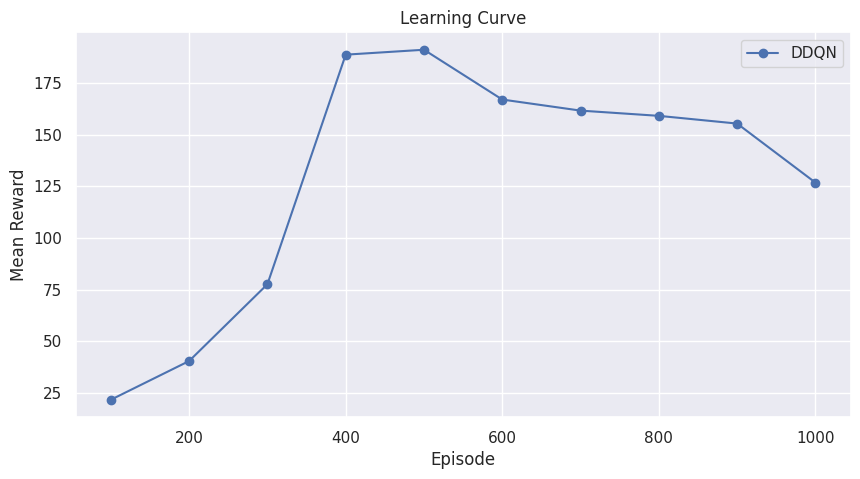

In [ ]:
plot_from_log_text(log_text, label="DDQN")